In [3]:
# !pip install datasets

# The Datasets Library.

APart from using the HugginFace Hub , mostly we'll be using data from local machine. To load data from local `datasets` library has a lot of functions to load various filetypes.


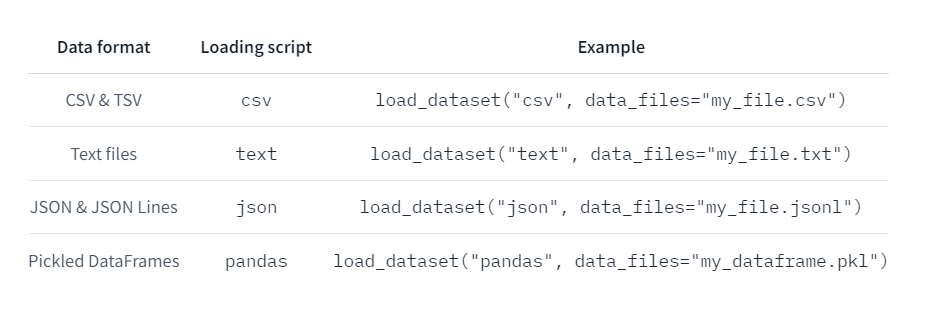

For this example we’ll use the **SQuAD-it dataset**, which is a large-scale dataset for question answering in Italian.

By default the `load_dataset()` loads the datatset into a `DatasetDict` format in train/test split.

In order to load the data , we need to know wether the data is in JSON or nested JSON format. Mostly all Q/A pairs are in nested format and the data is stored in `data` field. *Hence we should specify that in the `load_dataset` function arguments.

In [ ]:
# !wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz
# !wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-test.json.gz

# !gzip -dkv SQuAD_it-*.json.gz

In [ ]:
from datasets import load_dataset

squad_it_dataset = load_dataset("json", data_files="SQuAD_it-train.json", field="data")

print("The DatasetDict object: ",squad_it_dataset)
print("One sample : ", squad_it_dataset["train"][0])


Generating train split: 0 examples [00:00, ? examples/s]

The DatasetDict object:  DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
})
One sample :  {'title': 'Terremoto del Sichuan del 2008', 'paragraphs': [{'context': "Il terremoto del Sichuan del 2008 o il terremoto del Gran Sichuan, misurato a 8.0 Ms e 7.9 Mw, e si è verificato alle 02:28:01 PM China Standard Time all' epicentro (06:28:01 UTC) il 12 maggio nella provincia del Sichuan, ha ucciso 69.197 persone e lasciato 18.222 dispersi.", 'qas': [{'answers': [{'answer_start': 29, 'text': '2008'}], 'id': '56cdca7862d2951400fa6826', 'question': 'In quale anno si è verificato il terremoto nel Sichuan?'}, {'answers': [{'answer_start': 232, 'text': '69.197'}], 'id': '56cdca7862d2951400fa6828', 'question': 'Quante persone sono state uccise come risultato?'}, {'answers': [{'answer_start': 29, 'text': '2008'}], 'id': '56d4f9902ccc5a1400d833c0', 'question': 'Quale anno ha avuto luogo il terremoto del Sichuan?'}, {'answers': [{'answer_start'

The data_files argument of the `load_dataset()` function is quite flexible and can be either a single file path, a list of file paths, or a dictionary that maps split names to file paths. You can also glob files that match a specified pattern according to the rules used by the Unix shell (e.g., you can glob all the JSON files in a directory as a single split by setting `data_files="*.json"`)

The loading scripts in 🤗 Datasets actually support automatic decompression of the input files including TAR, GZ, ZIP etc. so we could have skipped the use of gzip by pointing the data_files argument directly to the compressed files:


In [ ]:
data_files = {"train": "SQuAD_it-train.json.gz", "test": "SQuAD_it-test.json.gz"}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# Slice and Dice the dataset.

Just like pandas the `datasets` library provide functions to manipulate data like the `map()` function we saw in last chapter.

For this example we'll use the **Drug Dataset**. It is a TSV file which is similar to CSV so it can be eaisly loaded by `load_dataset` function.

In [ ]:
# !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
# !unzip drugsCom_raw.zip
# !pip install datasets

In [ ]:
from datasets import load_dataset

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
# \t is the tab character in Python
drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

For doing any sort of data analysis is to take a few samples from the whole data and then work on it. For this the dataset library provide the `.shuffle()` method and `dataset.select()` method.

We'll use it together to create a sense of randomness in selection (seed is set for reproducability) The range is set to 1000 to get a thousand samples.

From this example we can see few things:
- The `Unnamed: 0` columns looks kinda like an index
- The `review` column contain some special characters that need cleaning.
- The `condition` column is of both upper and lower case.


In [ ]:
drug_sample = drug_dataset["train"].shuffle(seed=42).select(range(1000))
# Peek at the first few examples
drug_sample[:1]

{'Unnamed: 0': [87571],
 'drugName': ['Naproxen'],
 'condition': ['Gout, Acute'],
 'review': ['"like the previous person mention, I&#039;m a strong believer of aleve, it works faster for my gout than the prescription meds I take. No more going to the doctor for refills.....Aleve works!"'],
 'rating': [9.0],
 'date': ['September 2, 2015'],
 'usefulCount': [36]}

Now we have to check weather the `Unnamed:0` column can be really used as an index or not then later rename the column using the `DatasetDict.rename_column() `

Convert the `condition` column to lowercase and then clean the `review` column.

The dataset also contain few None values as evidenced by the error:
```
def lowercase_condition(example):
  return {"condition": example["condition"].lower()}


AttributeError: 'NoneType' object has no attribute 'lower'
```
**Hence we need to remove None values too**

In [ ]:
import html

for split in drug_dataset.keys():
    print(len(drug_dataset[split]) == len(drug_dataset[split].unique("Unnamed: 0")))
drug_dataset = drug_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="patient_id"
)

def lowercase_condition(example):
    return {"condition": example["condition"].lower()}

# Removing None values:
drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)
# converting condition column to lowercase
drug_dataset.map(lowercase_condition)

text = "I&#039;m a transformer called BERT"
print("Removing HTML : ",html.unescape(text))

drug_dataset = drug_dataset.map(lambda x: {"review": html.unescape(x["review"])})

drug_dataset["train"]["condition"][:3]

True
True


Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53766 [00:00<?, ? examples/s]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

Removing HTML :  I'm a transformer called BERT


Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

['Left Ventricular Dysfunction', 'ADHD', 'Birth Control']

**The map() function superpowers**

The map function takes in `batched` argumnet if it sets to `True` then it would sent the data as batches (The default is 1000 and can be changed).

When you specify `batched=True` the function receives a dictionary with the fields of the dataset, but each value is now a list of values, and not just a single value.

The return value of `Dataset.map()` should be the same: a dictionary with the fields we want to update or add to our dataset, and a list of values.

The below code executes **waay faster** than the previous one.

In [ ]:
new_drug_dataset = drug_dataset.map(
    lambda x: {"review": [html.unescape(o) for o in x["review"]]}, batched=True
)
new_drug_dataset

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 160398
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53471
    })
})

Using `batched = True` is essential to unlock the fast tokenizer capabilities.Using a fast tokenizer with the batched=True option is 30 times faster than its slow counterpart with no batching.

Parallelization also helps so having the work split the data in batches and then process each one of them parallely helps a lot. `Dataset.map()` also has some parallelization capabilities of its own.

To enable multiprocessing, use the `num_proc` argument and specify the number of processes to use in your call to `Dataset.map()`. Use the multiprocessing untill some function you use **has multiprocessing on its own**.

`tokenized_dataset = drug_dataset.map(slow_tokenize_function, batched=True, num_proc=8)`

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_and_split(examples):
    return tokenizer(
        examples["review"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
    )

result = tokenize_and_split(drug_dataset["train"][0])
print([len(inp) for inp in result["input_ids"]])

tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)

[25]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

ArrowInvalid: Column 7 named input_ids expected length 1000 but got length 1397

The Dataset.map() is cool but with that you can also  can change the number of elements in your dataset, this is super useful for other NLP tasks.

In machine learning we pass 'examples' which are a set of features to the model. In some context these features will be a set of columns in `Dataset`. In here multiple features can be extracted from a single example and belong to a single column.

Let's have a look at it, we'll truncate the dataset to `max_length` of 128, but we will ask the tokenizer to return all the chunks of the texts instead of just the first one. This can be done with `return_overflowing_tokens=True`. **As done above**


**The problem here** is that the datasets are different in size, the `drug_dataset` has 1000 features (from the error) while the resultant `tokenized_dataset` have features more than 1400+. it is more than 1,000 because we are tokenizing long reviews into more than one example by using return_overflowing_tokens=True.

That doesn’t work for a Dataset, so we need to either remove the columns from the old dataset or make them the same size as they are in the new dataset.

In [ ]:
tokenized_dataset = drug_dataset.map(
    tokenize_and_split, batched=True, remove_columns=drug_dataset["train"].column_names
)

len(tokenized_dataset["train"]), len(drug_dataset["train"])

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

(228656, 160398)

We mentioned that we can also deal with the mismatched length problem by making the old columns the same size as the new ones. To do this, we will need the `overflow_to_sample_mapping` field the tokenizer returns when we set `return_overflowing_tokens=True`

It provides us with a mapping from a newly created feature index back to the original sample index. By doing this, we can repeat the values of each example as many times as it produces new features, allowing us to associate each key in our original dataset with a list of values of the appropriate size:

In [ ]:
def tokenize_and_split(examples):
    result = tokenizer(
        examples["review"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
    )
    # Extract mapping between new and old indices
    sample_map = result.pop("overflow_to_sample_mapping")
    for key, values in examples.items():
        result[key] = [values[i] for i in sample_map]
    return result

tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)
tokenized_dataset

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 228656
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 76239
    })
})

# From Datasets to DataFrames and back

🤗 Datasets provide the `set_format()` which can change the output format of the `DatasetDict` without affecting the underlying data format, which is Apache Arrow.

In [ ]:
drug_dataset.set_format("pandas")
drug_dataset["train"][:3]

,patient_id,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17


Under the hood the `set_fortmat()` function returns a dunder method `__getitem__` This means that when we want to create a new object like train_df from a Dataset in the "pandas" format, we need to slice the whole dataset to obtain a pandas.DataFrame.

In [ ]:
train_df  = drug_dataset["train"][:]
train_df.head(3)

,patient_id,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17


In [ ]:
frequencies = (
    train_df["condition"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "condition", "condition": "frequency"})
)
frequencies.head()

,frequency,count
0,Birth Control,28788
1,Depression,9069
2,Pain,6145
3,Anxiety,5904
4,Acne,5588


In [ ]:
from datasets import Dataset

freq_dataset = Dataset.from_pandas(frequencies)
freq_dataset

Dataset({
    features: ['frequency', 'count'],
    num_rows: 884
})

# Saving and Loading

where we can see that each split is associated with its own dataset.arrow table, and some metadata in dataset_info.json and state.json. You can think of the Arrow format as a fancy table of columns and rows that is optimized for building high-performance applications that process and transport large datasets.

In [ ]:
drug_dataset_clean.save_to_disk("drug-reviews")

# This is the format the data will be saved.
"""
drug-reviews/
├── dataset_dict.json
├── test
│   ├── dataset.arrow
│   ├── dataset_info.json
│   └── state.json
├── train
│   ├── dataset.arrow
│   ├── dataset_info.json
│   ├── indices.arrow
│   └── state.json
└── validation
    ├── dataset.arrow
    ├── dataset_info.json
    ├── indices.arrow
    └── state.json
    """

# Once saved you can load data from disk

from datasets import load_from_disk

drug_dataset_reloaded = load_from_disk("drug-reviews")
drug_dataset_reloaded

# Big data in Datasets 🤗

Nowadays we need to load large ammount of data for training models like GPT2 , BERT etc. Loading for example `Webtext` data which is 40GB in RAM is impossible task.

To overcome this the `datasets` library has many features like **memory mapping** and **streaming** data. In this section we’ll explore these features of 🤗 Datasets with a huge 825 GB corpus known as the Pile (an English text corpus that was created by EleutherAI for training large-scale language models)

*We'll be using the same drug dataset as in the previous section*

In [ ]:
# !pip install zstandard
# !pip install datasets
# !pip install psutil

In [ ]:
from datasets import load_dataset
from datasets import DownloadConfig

delete_config = DownloadConfig(delete_extracted = True)
data_files = "https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz"
drug_dataset = load_dataset("json", data_files=data_files, split="train", download_config=delete_config)
drug_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['data', 'version'],
    num_rows: 442
})

If you want to preserve hard drive space, you can pass
`DownloadConfig(delete_extracted=True)`

- One way to map memory in python is using the `psutil` librray in python.
- Here the rss attribute refers to the resident set size, which is the fraction of memory that a process occupies in RAM. This measurement also includes the memory used by the Python interpreter and the libraries we’ve loaded, so the actual amount of memory used to load the dataset is a bit smaller

In [ ]:
import psutil

# Process.memory_info is expressed in bytes, so convert to megabytes
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

RAM used: 272.95 MB


🤗 Datasets treats each dataset as a memory-mapped file, which provides a mapping between RAM and filesystem storage that allows the library to access and operate on elements of the dataset without needing to fully load it into memory.

Memory-mapped files can also be shared across multiple processes, which enables methods like `Dataset.map()` to be parallelized .Under the hood, these capabilities are all realized by the `Apache Arrow memory` format and `pyarrow` library.

**🤗 Datasets provides a streaming feature that allows us to download and access elements on the fly, without needing to download the whole dataset**

In [ ]:
from transformers import AutoTokenizer

dataset_streamed = load_dataset("json", data_files=data_files, split="train", streaming=True)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenized_dataset = dataset_streamed.map(lambda x: tokenizer(x["data"]))

shuffled_dataset = dataset_streamed.shuffle(buffer_size=10_000, seed=42)

In [ ]:
# Skip the first 1,000 examples and include the rest in the training set
train_dataset = shuffled_dataset.skip(1000)
# Take the first 1,000 examples for the validation set
validation_dataset = shuffled_dataset.take(1000)

🤗 Datasets provides an interleave_datasets() function that converts a list of IterableDataset objects into a single IterableDataset, where the elements of the new dataset are obtained by alternating among the source examples


# Creating your own dataset

- Exploring how long does it take to close an pull request.
- Training a classifier based on the metadata, ("bug","enhancement", or "question").
- Creating a semantic search engine to match user query to the issues already present.


In [ ]:
import requests

url = "https://api.github.com/repos/huggingface/datasets/issues?page=1&per_page=1"
response = requests.get(url)
response.status_code

200

In [ ]:
# GITHUB_TOKEN = # Copy your GitHub token here
# headers = {"Authorization": f"token {GITHUB_TOKEN}"}

In [ ]:
import time
import math
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm


def fetch_issues(
    owner="huggingface",
    repo="datasets",
    num_issues=100,
    rate_limit=50,
    issues_path=Path("."),
):
    if not issues_path.is_dir():
        issues_path.mkdir(exist_ok=True)

    batch = []
    all_issues = []
    per_page = 100  # Number of issues to return per page
    num_pages = math.ceil(num_issues / per_page)
    base_url = "https://api.github.com/repos"

    for page in tqdm(range(num_pages)):
        # Query with state=all to get both open and closed issues
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}", headers=headers)
        batch.extend(issues.json())

        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = []  # Flush batch for next time period
            print(f"Reached GitHub rate limit. Sleeping for one hour ...")
            time.sleep(10)

    all_issues.extend(batch)
    df = pd.DataFrame.from_records(all_issues)
    df.to_json(f"{issues_path}/{repo}-issues.jsonl", orient="records", lines=True)
    print(
        f"Downloaded all the issues for {repo}! Dataset stored at {issues_path}/{repo}-issues.jsonl")

In [ ]:
# Depending on your internet connection, this can take several minutes to run...
fetch_issues()

  0%|          | 0/1 [00:00<?, ?it/s]

Reached GitHub rate limit. Sleeping for one hour ...
Downloaded all the issues for datasets! Dataset stored at ./datasets-issues.jsonl


In [ ]:
issues_dataset = load_dataset("json", data_files="datasets-issues.jsonl", split="train")
issues_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['url', 'repository_url', 'labels_url', 'comments_url', 'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments', 'created_at', 'updated_at', 'closed_at', 'author_association', 'active_lock_reason', 'draft', 'pull_request', 'body', 'reactions', 'timeline_url', 'performed_via_github_app', 'state_reason'],
    num_rows: 100
})

A dataset is to be created from the `raw_datasets` of issues from github. Since we have not autheticated Github via token we're only downloading some 100 issues ig at this momment. To avoid eeceeding the limit of requests we can download by batches.


*GitHub’s REST API v3 considers every pull request an issue, but not every issue is a pull request. For this reason, “Issues” endpoints may return both issues and pull requests in the response. You can identify pull requests by the pull_request key. Be aware that the id of a pull request returned from “Issues” endpoints will be an issue id.*

Since the contents of issues and pull requests are quite different, let’s do some minor preprocessing to enable us to distinguish between them.

**Cleaning up and Augmenting data**

We'll see a random sample to check out `pull_request` column.

In [ ]:
sample = issues_dataset.shuffle(seed=666).select(range(3))

# Print out the URL and pull request entries
for url, pr in zip(sample["html_url"], sample["pull_request"]):
    print(f">> URL: {url}")
    print(f">> Pull request: {pr}\n")

>> URL: https://github.com/huggingface/datasets/pull/6943
>> Pull request: {'url': 'https://api.github.com/repos/huggingface/datasets/pulls/6943', 'html_url': 'https://github.com/huggingface/datasets/pull/6943', 'diff_url': 'https://github.com/huggingface/datasets/pull/6943.diff', 'patch_url': 'https://github.com/huggingface/datasets/pull/6943.patch', 'merged_at': datetime.datetime(2024, 6, 3, 5, 17, 40)}

>> URL: https://github.com/huggingface/datasets/pull/6998
>> Pull request: {'url': 'https://api.github.com/repos/huggingface/datasets/pulls/6998', 'html_url': 'https://github.com/huggingface/datasets/pull/6998', 'diff_url': 'https://github.com/huggingface/datasets/pull/6998.diff', 'patch_url': 'https://github.com/huggingface/datasets/pull/6998.patch', 'merged_at': datetime.datetime(2024, 6, 25, 8, 13, 42)}

>> URL: https://github.com/huggingface/datasets/issues/6913
>> Pull request: None



Here we can see that each pull request is associated with various URLs, while ordinary issues have a None entry. We can use this distinction to create a new is_pull_request column that checks whether the pull_request field is None or not:

- Also it a good practice to keep dataset as raw untill we're finished with all the cleaning of data.

- Comments are stored in the body field, so let’s write a simple function that returns all the comments associated with an issue by picking out the body contents for each element in `response.json()`

In [ ]:
issues_dataset = issues_dataset.map(
    lambda x: {"is_pull_request": False if x["pull_request"] is None else True})

def get_comments(issue_number):
    url = f"https://api.github.com/repos/huggingface/datasets/issues/{issue_number}/comments"
    response = requests.get(url, headers=headers)
    return [r["body"] for r in response.json()]


# Test our function works as expected
get_comments(100)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

['LGTM :-) Some small suggestions to shorten the code a bit :-) ',
 'Can you put the kwargs as normal kwargs instead of a dict? (And add them to the kwargs description As well)',
 '@thom Is-it what you meant?',
 'Yes and there is a dynamically generated doc string in the metric script KWARGS DESCRIPTION']

This looks good, so let’s use Dataset.map() to add a new comments column to each issue in our dataset:

In [ ]:
issues_with_comments_dataset = issues_dataset.map(lambda x: {"comments": get_comments(x["number"])})
url = f"https://api.github.com/repos/huggingface/datasets/issues/{908}/comments"
response = requests.get(url)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
issues_with_comments_dataset.push_to_hub("github-issues")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/kailasps/github-issues/commit/b6a6c4d1acd655471da428e552a7b7e56518b9f0', commit_message='Upload dataset', commit_description='', oid='b6a6c4d1acd655471da428e552a7b7e56518b9f0', pr_url=None, pr_revision=None, pr_num=None)

# Semantic search with FAISS
### Facebook AI Similarity Search.

Transformer based model represent each token in a span of text as an **embedding vector.** We can pool the individual embedidngs to create one embedding for the whole sentence.


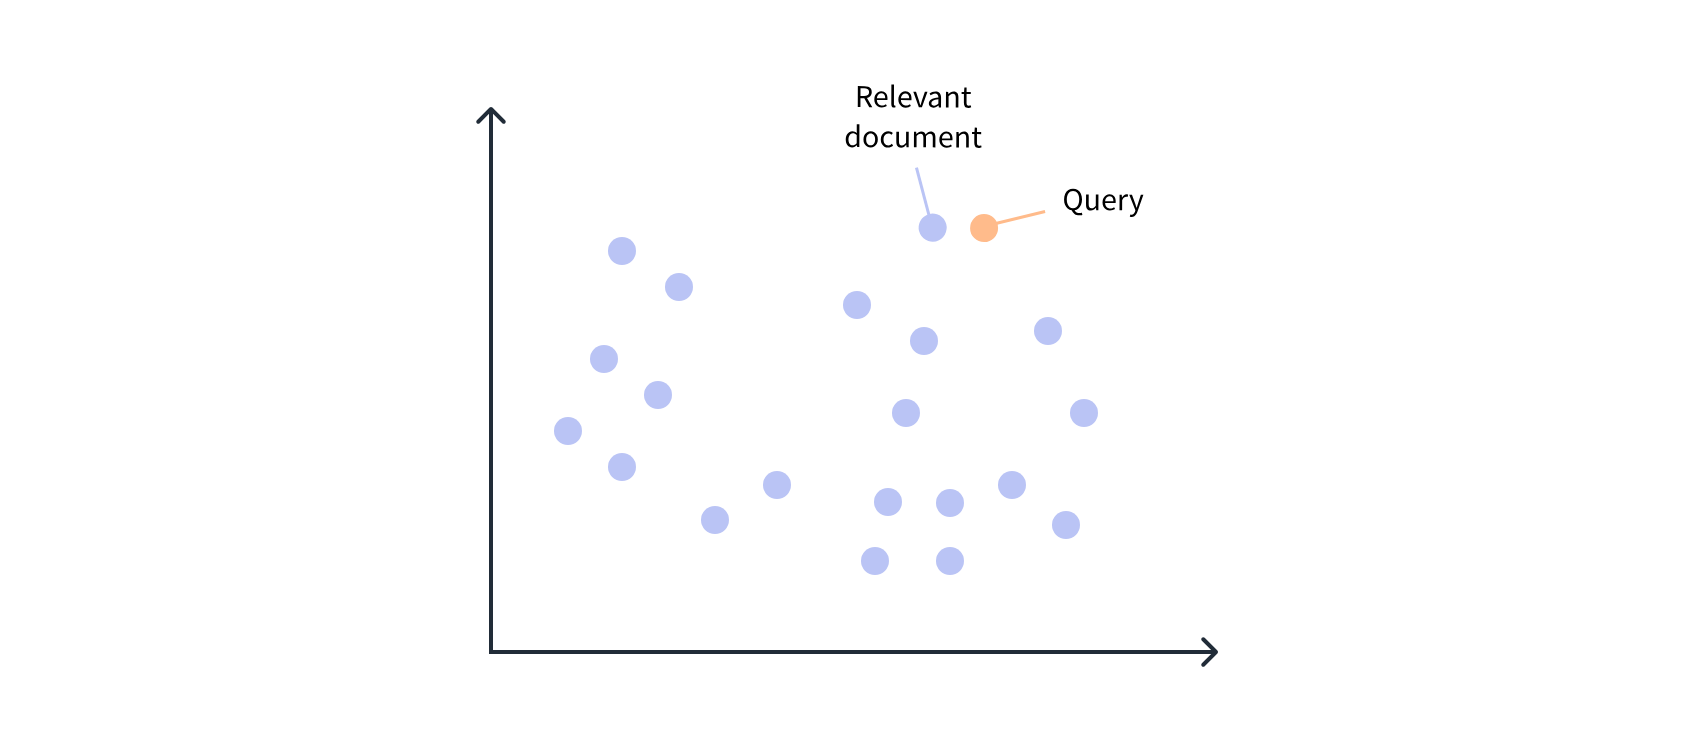

**Loading the dataset**

The first order of business is to filter out the pull requests, as these tend to be rarely used for answering user queries and will introduce noise in our search engine.We can use the `Dataset.filter()`

- We have a lot of columns too, from a search point of view what we need is just few columns like `title`, `body`, and `comments `. We'll use `Dataset.remove_columns` to remove columns.

In [2]:
from datasets import load_dataset

issues_dataset = load_dataset("lewtun/github-issues", split="train")

issues_dataset = issues_dataset.filter(lambda x: (x["is_pull_request"] == False and len(x["comments"]) > 0))
issues_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['url', 'repository_url', 'labels_url', 'comments_url', 'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments', 'created_at', 'updated_at', 'closed_at', 'author_association', 'active_lock_reason', 'pull_request', 'body', 'timeline_url', 'performed_via_github_app', 'is_pull_request'],
    num_rows: 808
})

In [3]:
columns = issues_dataset.column_names
columns_to_keep = ["title", "body", "html_url", "comments"]
columns_to_remove = set(columns_to_keep).symmetric_difference(columns)
issues_dataset = issues_dataset.remove_columns(columns_to_remove)
issues_dataset

Dataset({
    features: ['html_url', 'title', 'comments', 'body'],
    num_rows: 808
})

We need to augment each comment with the `title` and `body` as these columns often contain a lot of contextual information. **Because our comments column is currently a list of comments for each issue**
- we need to “explode” the column so that each row consists of an `html_url, title, body, comment`
-Pandas we can do this with the `DataFrame.explode()` function

In [4]:
issues_dataset.set_format("pandas")
df = issues_dataset[:]
df["comments"][0].tolist()

['Cool, I think we can do both :)',
 '@lhoestq now the 2 are implemented.\r\n\r\nPlease note that for the the second protection, finally I have chosen to protect the master branch only from **merge commits** (see update comment above), so no need to disable/re-enable the protection on each release (direct commits, different from merge commits, can be pushed to the remote master branch; and eventually reverted without messing up the repo history).']

In [5]:
comments_df = df.explode("comments", ignore_index=True)
comments_df.head(3)

,html_url,title,comments,body
0,https://github.com/huggingface/datasets/issues...,Protect master branch,"Cool, I think we can do both :)",After accidental merge commit (91c55355b634d0d...
1,https://github.com/huggingface/datasets/issues...,Protect master branch,@lhoestq now the 2 are implemented.\r\n\r\nPle...,After accidental merge commit (91c55355b634d0d...
2,https://github.com/huggingface/datasets/issues...,Backwards compatibility broken for cached data...,Hi ! I guess the caching mechanism should have...,## Describe the bug\r\nAfter upgrading to data...


In [6]:
from datasets import Dataset

comments_dataset = Dataset.from_pandas(comments_df)
print(comments_dataset)

# Creating a comment_length column

comments_dataset = comments_dataset.map(
    lambda x: {"comment_length": len(x["comments"].split())})

Dataset({
    features: ['html_url', 'title', 'comments', 'body'],
    num_rows: 2964
})


Map:   0%|          | 0/2964 [00:00<?, ? examples/s]

- Nect we need to filter the comment column by removing shorter comments from the dataset.
- After that we concatenate `title, body and comments` in on string.

In [7]:
# Filtering short comments
comments_dataset = comments_dataset.filter(lambda x: x["comment_length"] > 15)

# concatination
def concatenate_text(examples):
    return {
        "text": examples["title"]
        + " \n "
        + examples["body"]
        + " \n "
        + examples["comments"]}


comments_dataset = comments_dataset.map(concatenate_text)

Filter:   0%|          | 0/2964 [00:00<?, ? examples/s]

Map:   0%|          | 0/2175 [00:00<?, ? examples/s]

**Creating Text embeddings**

As we mentioned earlier, we’d like to represent each entry in our GitHub issues corpus as a single vector, so we need to “pool” or average our token embeddings in some way. One popular approach is to perform CLS pooling on our model’s outputs, where we simply collect the last hidden state for the special [CLS] token. The following function does the trick for us:

In [8]:
from transformers import AutoTokenizer, AutoModel
import torch

model_ckpt = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

device = torch.device("cuda")
model.to(device)

def cls_pooling(model_output):
    return model_output.last_hidden_state[:, 0]

def get_embeddings(text_list):
    encoded_input = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt")
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    model_output = model(**encoded_input)
    return cls_pooling(model_output)

embedding = get_embeddings(comments_dataset["text"][0])
embedding.shape

torch.Size([1, 768])

In [9]:
# We can use Dataset.map() to apply our get_embeddings() function to each row in our corpus and also create a "embedding" column as well
embeddings_dataset = comments_dataset.map(lambda x: {"embeddings": get_embeddings(x["text"]).detach().cpu().numpy()[0]})

Map:   0%|          | 0/2175 [00:00<?, ? examples/s]

Notice that we’ve converted the embeddings to NumPy arrays — that’s because 🤗 Datasets requires this format when we try to index them with FAISS, which we’ll do next.

**Using FAISS for efficient similarity search**

We’ll use a special data structure in 🤗 Datasets called a FAISS index. FAISS (short for Facebook AI Similarity Search) is a library that provides efficient algorithms to quickly search and cluster embedding vectors.

- The basic idea behind FAISS is to create a special data structure called an **index** that allows one to find which embeddings are similar to an input embedding. Creating a FAISS index in 🤗 Datasets is simple — we use the `Dataset.add_faiss_index()` function and specify which column of our dataset we’d like to index
- We use `Dataset.get_nearest_examples()` to search up the similar docs



In [10]:
!pip install faiss-gpu

In [11]:
embeddings_dataset.add_faiss_index(column="embeddings")

question = "How can I load a dataset offline?"
question_embedding = get_embeddings([question]).cpu().detach().numpy()
question_embedding.shape

  0%|          | 0/3 [00:00<?, ?it/s]

(1, 768)

The Dataset.get_nearest_examples() function returns a tuple of scores that rank the overlap between the query and the document, and a corresponding set of samples (here, the 5 best matches). Let’s collect these in a pandas.DataFrame so we can easily sort them:



In [12]:
import pandas as pd

scores, samples = embeddings_dataset.get_nearest_examples(
    "embeddings", question_embedding, k=5)

samples_df = pd.DataFrame.from_dict(samples)
samples_df["scores"] = scores
samples_df.sort_values("scores", ascending=False, inplace=True)

In [14]:
samples_df

,html_url,title,comments,body,comment_length,text,embeddings,scores
4,https://github.com/huggingface/datasets/issues...,Discussion using datasets in offline mode,Requiring online connection is a deal breaker ...,"`datasets.load_dataset(""csv"", ...)` breaks if ...",57,Discussion using datasets in offline mode \n `...,"[-0.4731806814670563, 0.24578382074832916, -0....",25.505037
3,https://github.com/huggingface/datasets/issues...,Discussion using datasets in offline mode,"The local dataset builders (csv, text , json a...","`datasets.load_dataset(""csv"", ...)` breaks if ...",38,Discussion using datasets in offline mode \n `...,"[-0.4490852952003479, 0.20950652658939362, -0....",24.555548
2,https://github.com/huggingface/datasets/issues...,Discussion using datasets in offline mode,I opened a PR that allows to reload modules th...,"`datasets.load_dataset(""csv"", ...)` breaks if ...",179,Discussion using datasets in offline mode \n `...,"[-0.4716479778289795, 0.2902272641658783, -0.0...",24.148977
1,https://github.com/huggingface/datasets/issues...,Discussion using datasets in offline mode,"> here is my way to load a dataset offline, bu...","`datasets.load_dataset(""csv"", ...)` breaks if ...",76,Discussion using datasets in offline mode \n `...,"[-0.4992601275444031, 0.22699788212776184, -0....",22.893993
0,https://github.com/huggingface/datasets/issues...,Discussion using datasets in offline mode,"here is my way to load a dataset offline, but ...","`datasets.load_dataset(""csv"", ...)` breaks if ...",47,Discussion using datasets in offline mode \n `...,"[-0.4902574121952057, 0.22889623045921326, -0....",22.406645
